# Set Up the Environment

### Importing Libraries

In [12]:

%pip install torchmetrics
%pip install  pytorch-msssim
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from datasets import load_dataset
import torchvision
from torchvision import transforms
from torchmetrics.image import StructuralSimilarityIndexMeasure
from transformers import AutoModelForDepthEstimation
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import time
import timm
import PIL
from PIL import Image
import requests
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.optim.lr_scheduler import CosineAnnealingLR
from tqdm import tqdm
from pytorch_msssim import ssim

### Mount Drive

In [2]:
from google.colab import drive

drive.mount('/content/drive')



Mounted at /content/drive


# Define Needed Classes & Functions

### Class for Depth Model

In [13]:
class DepthModel(nn.Module):
    """
    Wrapper class for the Depth-Anything model.
    """
    def __init__(self, mod):
        super().__init__()
        self.model = mod
        self.eval()

    def forward(self, x):
        original_size = x.shape[2:]
        outputs = self.model(x)
        predicted_depth = outputs.predicted_depth
        # The shape is (batch, channel, height, width), so unpack accordingly
        # print(predicted_depth.shape) # Keep for debugging if needed

        # Ensure the tensor has 4 dimensions
        if predicted_depth.dim() == 3:
             predicted_depth = predicted_depth.unsqueeze(1) # Add a batch dimension if it's missing

        b, c, h, w = predicted_depth.shape
        predicted_depth_flat = predicted_depth.view(b, -1)
        # Find the max value for each image in the batch
        max_vals = predicted_depth_flat.max(dim=1, keepdim=True)[0]
        # Avoid division by zero
        max_vals[max_vals == 0] = 1.0
        # Normalize the teacher's depth map to [0, 1]
        predicted_depth_normalized = predicted_depth_flat / max_vals
        predicted_depth_normalized = predicted_depth_normalized.view(b, c, h, w) # Reshape back to original dimensions
        # Remove the extra channel dimension before interpolation
        predicted_depth_normalized = F.interpolate(predicted_depth_normalized, size=original_size, mode='bilinear', align_corners=False)
        return predicted_depth_normalized

### Class for Student Model

In [14]:
# Create a dummy input tensor
dummy_input = torch.randn(1, 3, 224, 224)

# Load the encoder
encoder = timm.create_model(
    'mobilevit_s',
    pretrained=True,
    features_only=True
)

# Pass the dummy input through the encoder
feature_maps = encoder(dummy_input)

# Print the shape of each feature map
print("Detected Feature Map Shapes (batch_size, channels, height, width):")
for i, fm in enumerate(feature_maps):
    print(f"Feature Map {i}: {fm.shape}")

print("\n----------------------------------")
print("Correct Channel Sizes to use in Decoder:")
for i, fm in enumerate(feature_maps):
    print(f"Skip Connection {i}: {fm.shape[1]} channels")


Detected Feature Map Shapes (batch_size, channels, height, width):
Feature Map 0: torch.Size([1, 32, 112, 112])
Feature Map 1: torch.Size([1, 64, 56, 56])
Feature Map 2: torch.Size([1, 96, 28, 28])
Feature Map 3: torch.Size([1, 128, 14, 14])
Feature Map 4: torch.Size([1, 640, 7, 7])

----------------------------------
Correct Channel Sizes to use in Decoder:
Skip Connection 0: 32 channels
Skip Connection 1: 64 channels
Skip Connection 2: 96 channels
Skip Connection 3: 128 channels
Skip Connection 4: 640 channels


In [15]:
class DecoderBlock(nn.Module):
    """
    A more complex decoder block with two convolutional layers and batch normalization.
    This helps in learning more robust features during the upsampling process.
    """
    def __init__(self, in_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels // 2, kernel_size=3, padding=1)
        self.norm1 = nn.BatchNorm2d(in_channels // 2)
        self.relu1 = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(in_channels // 2, out_channels, kernel_size=3, padding=1)
        self.norm2 = nn.BatchNorm2d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.norm2(x)
        x = self.relu2(x)
        return x

In [16]:
class StudentModel(nn.Module):
    """
    Student model with a MobileViT-S encoder and a custom decoder.
    This version adds the ability to freeze the initial encoder layers for fine-tuning.
    """
    def __init__(self, output_channels=1, freeze_up_to=2):
        """
        Initializes the StudentModel.
        Args:
            output_channels (int): Number of output channels (e.g., 1 for depth).
            freeze_up_to (int): How many of the main encoder blocks to freeze.
                                0: Unfreezes all layers.
                                1: Freezes the initial conv_stem.
                                2: Freezes conv_stem and the first main block, etc.
        """
        super(StudentModel, self).__init__()

        # Load the pretrained MobileViT-S encoder
        self.encoder = timm.create_model(
            'mobilevit_s',
            pretrained=True,
            features_only=True
        )

        # --- Layer Freezing Logic ---
        # We iterate through the modules of the encoder by index.
        # This is robust and doesn't rely on internal names.
        for i, module in enumerate(self.encoder.children()):
            if i < freeze_up_to:
                print(f"Freezing encoder module {i}")
                for param in module.parameters():
                    param.requires_grad = False
            else:
                print(f"Unfreezing encoder module {i}")
        # ------------------------------------

        # Channel Dimensions from your output:
        # -----------------------------------------------
        # Skip Connection 0: 32 channels
        # Skip Connection 1: 64 channels
        # Skip Connection 2: 96 channels
        # Skip Connection 3: 128 channels
        # Skip Connection 4: 640 channels (final encoder output)

       # Enhanced decoder blocks
        self.decoder_block1 = DecoderBlock(640 + 128, 128)
        self.decoder_block2 = DecoderBlock(128 + 96, 96)
        self.decoder_block3 = DecoderBlock(96 + 64, 64)
        self.decoder_block4 = DecoderBlock(64 + 32, 32)
        self.decoder_block5 = DecoderBlock(32, 16)

        # Final convolution to get the desired output channels
        self.final_conv = nn.Sequential(
            nn.Conv2d(16, output_channels, kernel_size=1),
            nn.Sigmoid()  # Use Sigmoid for outputs between 0 and 1
        )

    def forward(self, x):
        original_size = x.shape[2:]

        # Get feature maps from the encoder
        skip_features = self.encoder(x)
        encoder_output = skip_features[4]

        # --- Decoder Path ---
        # Upsample -> Concatenate with skip connection -> Pass through DecoderBlock

        x = F.interpolate(encoder_output, size=skip_features[3].shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, skip_features[3]], dim=1)
        x = self.decoder_block1(x)

        x = F.interpolate(x, size=skip_features[2].shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, skip_features[2]], dim=1)
        x = self.decoder_block2(x)

        x = F.interpolate(x, size=skip_features[1].shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, skip_features[1]], dim=1)
        x = self.decoder_block3(x)

        x = F.interpolate(x, size=skip_features[0].shape[2:], mode='bilinear', align_corners=False)
        x = torch.cat([x, skip_features[0]], dim=1)
        x = self.decoder_block4(x)

        # Final upsampling and processing
        x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
        x = self.decoder_block5(x)

        # Generate final output
        x = self.final_conv(x)
        x = F.interpolate(x, size=original_size, mode='bilinear', align_corners=False)
        return x

### Class for Dataset Loading & Preprocessing

In [17]:
class UnlabeledImageDataset(Dataset):
    """
    Custom dataset for unlabeled images.
    """
    def __init__(self, root_dir, transform=None, resize_size=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(root_dir, f) for f in os.listdir(root_dir) if f.endswith(('png', 'jpg', 'JPG'))]
        self.resize_size = resize_size
        print(f"Found {len(self.image_paths)} images in {root_dir}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')

        if self.resize_size:
            image = image.resize(self.resize_size)

        if self.transform:
            image = self.transform(image)


        return image

### Distillation Loss

In [18]:
class DepthDistillationLoss(nn.Module):
    """
    Custom loss function for depth distillation.
    Using Pixel wise MSE Loss, SSIM, Gradient MAE Loss, and Scale-Invariant MSE Loss.
    """
    def __init__(self, lambda_depth=1.0, lambda_si=1.0, lambda_grad=1.0, lambda_ssim=1.0, window_size=11):
        super().__init__()
        self.lambda_depth = lambda_depth   # Weight for depth map MSE loss
        self.lambda_si = lambda_si         # Weight for Scale-Invariant MSE loss
        self.lambda_grad = lambda_grad     # Weight for Gradient loss
        self.lambda_ssim = lambda_ssim     # Weight for SSIM loss

        self.mse_depth_loss = nn.MSELoss()  # Mean Squared Error for depth maps
        self.l1_loss = nn.L1Loss()          # L1 Loss for gradients

        # Initialize the SSIM calculation from torchmetrics
        self.ssim = StructuralSimilarityIndexMeasure(data_range=1.0, kernel_size=window_size)

    def forward(self, student_outputs, teacher_outputs):
        student_depth = student_outputs
        teacher_depth = teacher_outputs

        # Ensure tensors have a batch dimension
        if student_depth.dim() == 3:
            student_depth = student_depth.unsqueeze(0)
        if teacher_depth.dim() == 3:
            teacher_depth = teacher_depth.unsqueeze(0)

        # Ensure tensors have a channel dimension for SSIM
        if student_depth.dim() == 3: # Assuming (Batch, Height, Width)
            student_depth = student_depth.unsqueeze(1) # Becomes (Batch, Channel, Height, Width)
        if teacher_depth.dim() == 3: # Assuming (Batch, Height, Width)
            teacher_depth = teacher_depth.unsqueeze(1) # Becomes (Batch, Channel, Height, Width)


        total_loss = torch.tensor(0.0, device=student_depth.device)

        # 1. MSE Depth Loss
        if self.lambda_depth > 0:
            loss_depth = self.mse_depth_loss(student_depth, teacher_depth)
            total_loss += self.lambda_depth * loss_depth

        # 2. Scale-Invariant MSE Loss
        if self.lambda_si > 0:
          # Add a small epsilon to avoid log(0)
          epsilon = 1e-6
          log_diff = torch.log(student_depth + epsilon) - torch.log(teacher_depth + epsilon)

          # Calculate the scale-invariant loss
          term1 = torch.mean(log_diff**2)
          term2 = (torch.mean(log_diff))**2
          loss_si = term1 - term2

          total_loss += self.lambda_si * loss_si

        # 3. Gradient Loss (using L1 on gradients)
        if self.lambda_grad > 0:
            student_grad_x = torch.abs(student_depth[:, :, :, :-1] - student_depth[:, :, :, 1:])
            student_grad_y = torch.abs(student_depth[:, :, :-1, :] - student_depth[:, :, 1:, :])
            teacher_grad_x = torch.abs(teacher_depth[:, :, :, :-1] - teacher_depth[:, :, :, 1:])
            teacher_grad_y = torch.abs(teacher_depth[:, :, :-1, :] - teacher_depth[:, :, 1:, :])

            loss_grad = self.l1_loss(student_grad_x, teacher_grad_x) + self.l1_loss(student_grad_y, teacher_grad_y)
            total_loss += self.lambda_grad * loss_grad

        # 4. SSIM Loss
        if self.lambda_ssim > 0:
            d_ssim = self.ssim(student_depth, teacher_depth)
            loss_ssim = (1 - d_ssim) / 2 # Normalize to be between 0 and 1
            total_loss += self.lambda_ssim * loss_ssim

        return total_loss

In [19]:
class CombinedDepthLoss(nn.Module):
    """
    A combined loss function for monocular depth estimation.
    It includes:
    1. Scale-Invariant Logarithmic (SILog) Loss for scale-invariant accuracy.
    2. Gradient Matching Loss (L1) for preserving sharp edges.
    3. Structural Similarity (SSIM) for perceptual quality.
    """
    def __init__(self, lambda_si=1.0, lambda_grad=1.0, lambda_ssim=0.85):
        super(CombinedDepthLoss, self).__init__()
        self.lambda_si = lambda_si
        self.lambda_grad = lambda_grad
        self.lambda_ssim = lambda_ssim

    def get_gradients(self, image):
        # Using Sobel filters for edge detection
        sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).view(1, 1, 3, 3).to(image.device)
        sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).view(1, 1, 3, 3).to(image.device)

        # We need to handle the single channel case for depth maps
        if image.dim() == 4 and image.size(1) == 1:
            grad_x = F.conv2d(image, sobel_x, padding=1)
            grad_y = F.conv2d(image, sobel_y, padding=1)
        else: # Assuming single image (C, H, W)
            image_unsqueezed = image.unsqueeze(0)
            grad_x = F.conv2d(image_unsqueezed, sobel_x, padding=1).squeeze(0)
            grad_y = F.conv2d(image_unsqueezed, sobel_y, padding=1).squeeze(0)

        return grad_x, grad_y

    def forward(self, student_outputs, teacher_outputs):
        # Ensure predictions are positive for log operations
        epsilon = 1e-8
        student_depth = torch.clamp(student_outputs, min=epsilon)
        teacher_depth = torch.clamp(teacher_outputs, min=epsilon)

        # 1. SILog Loss
        log_diff = torch.log(student_depth) - torch.log(teacher_depth)
        loss_si = torch.mean(log_diff**2) - (torch.mean(log_diff))**2

        # 2. Gradient Matching Loss
        student_grad_x, student_grad_y = self.get_gradients(student_depth)
        teacher_grad_x, teacher_grad_y = self.get_gradients(teacher_depth)
        loss_grad = F.l1_loss(student_grad_x, teacher_grad_x) + F.l1_loss(student_grad_y, teacher_grad_y)

        # 3. SSIM Loss
        # Ensure data_range is set appropriately. If your depth is normalized to [0,1], this is fine.
        loss_ssim_val = ssim(student_depth, teacher_depth, data_range=1.0, size_average=True)
        loss_ssim = (1 - loss_ssim_val) / 2 # SSIM is a similarity metric, so we convert it to a loss

        # Combine the losses
        total_loss = (self.lambda_si * loss_si) + \
                     (self.lambda_grad * loss_grad) + \
                     (self.lambda_ssim * loss_ssim)

        return total_loss


In [26]:
class FocalLoss(nn.Module):
    """
    Focal Loss to focus training on hard-to-predict pixels.
    """
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt)**self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

def total_variation_loss(img, weight=1.0):
    """
    Total Variation Loss to encourage smoothness in the output depth map.
    """
    bs_img, c_img, h_img, w_img = img.size()
    tv_h = torch.pow(img[:, :, 1:, :] - img[:, :, :-1, :], 2).sum()
    tv_w = torch.pow(img[:, :, :, 1:] - img[:, :, :, :-1], 2).sum()
    return weight * (tv_h + tv_w) / (bs_img * c_img * h_img * w_img)


class EnhancedCombinedDepthLoss(nn.Module):
    """
    An enhanced combined loss function for depth estimation with trainable weights.
    Combines Scale-Invariant Loss, Gradient Loss, SSIM, Focal Loss, and TV Loss.
    """
    def __init__(self, lambda_si=1.0, lambda_grad=1.0, lambda_ssim=0.8, lambda_focal=0.5, lambda_tv=0.1):
        super(EnhancedCombinedDepthLoss, self).__init__()

        # Turn loss weights into trainable parameters
        self.log_lambda_si = nn.Parameter(torch.tensor(lambda_si).log())
        self.log_lambda_grad = nn.Parameter(torch.tensor(lambda_grad).log())
        self.log_lambda_ssim = nn.Parameter(torch.tensor(lambda_ssim).log())
        self.log_lambda_focal = nn.Parameter(torch.tensor(lambda_focal).log())
        self.log_lambda_tv = nn.Parameter(torch.tensor(lambda_tv).log())

        self.focal_loss = FocalLoss()

    def ssim(self, x, y):
        # Simplified SSIM calculation for brevity
        C1 = 0.01**2
        C2 = 0.03**2
        mu_x = F.avg_pool2d(x, 3, 1, 1)
        mu_y = F.avg_pool2d(y, 3, 1, 1)
        sigma_x = F.avg_pool2d(x**2, 3, 1, 1) - mu_x**2
        sigma_y = F.avg_pool2d(y**2, 3, 1, 1) - mu_y**2
        sigma_xy = F.avg_pool2d(x * y, 3, 1, 1) - mu_x * mu_y
        SSIM_n = (2 * mu_x * mu_y + C1) * (2 * sigma_xy + C2)
        SSIM_d = (mu_x**2 + mu_y**2 + C1) * (sigma_x + sigma_y + C2)
        return torch.clamp((1 - SSIM_n / SSIM_d) / 2, 0, 1)

    def gradient_loss(self, prediction, target):
        # Sobel filters for edge detection
        sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).view(1, 1, 3, 3).to(prediction.device)
        sobel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).view(1, 1, 3, 3).to(prediction.device)

        pred_grad_x = F.conv2d(prediction, sobel_x, padding=1)
        pred_grad_y = F.conv2d(prediction, sobel_y, padding=1)
        target_grad_x = F.conv2d(target, sobel_x, padding=1)
        target_grad_y = F.conv2d(target, sobel_y, padding=1)

        grad_loss = F.l1_loss(pred_grad_x, target_grad_x) + F.l1_loss(pred_grad_y, target_grad_y)
        return grad_loss

    def forward(self, prediction, target):
        # Ensure target is not all zero to avoid division by zero
        valid_mask = target > 0

        # Scale-Invariant Loss (SILog)
        log_diff = torch.log(prediction[valid_mask]) - torch.log(target[valid_mask])
        si_loss = torch.mean(log_diff**2) - 0.5 * (torch.mean(log_diff)**2)

        # Gradient Loss
        grad_loss = self.gradient_loss(prediction, target)

        # SSIM Loss
        ssim_loss = torch.mean(self.ssim(prediction, target))

        # Focal Loss
        focal_loss = self.focal_loss(prediction, target)

        # Total Variation Loss
        tv_loss = total_variation_loss(prediction)

        # Combine losses with trainable weights
        # We use exp(log_lambda) to ensure the weights are always positive
        total_loss = (torch.exp(self.log_lambda_si) * si_loss +
                      torch.exp(self.log_lambda_grad) * grad_loss +
                      torch.exp(self.log_lambda_ssim) * ssim_loss +
                      torch.exp(self.log_lambda_focal) * focal_loss +
                      torch.exp(self.log_lambda_tv) * tv_loss)

        return total_loss

### The Training Function

In [20]:
def train_knowledge_distillation(teacher, student, train_dataloader, val_dataloader, criterion, optimizer, epochs, device):
    """
    Train the student model using Response-Based knowledge distillation.
    """
    teacher.eval() # Teacher should always be in evaluation mode

    print(f"Starting Knowledge Distillation Training on {device}...")
    min_loss = float('inf')
    for epoch in range(epochs):
        student.train() # Student in training mode
        running_loss = 0.0
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}")
        start_time = time.time()

        for images in progress_bar:
            images = images.to(device)
            optimizer.zero_grad()

            # Forward pass with Teacher model (no_grad as teacher is fixed)
            with torch.no_grad():
                teacher_outputs = teacher(images) # Returns depth map

            # Forward pass with Student model
            student_outputs = student(images) # Returns depth map

            # Calculate distillation loss
            loss = criterion(student_outputs, teacher_outputs)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()


        epoch_loss = running_loss / len(train_dataloader)
        current_lr = scheduler.get_last_lr()[0]
        end_time = time.time()
        print(f"End of Epoch {epoch+1},Time: {end_time - start_time:.2f}s, Current LR: {current_lr:.6f}, Average Loss: {epoch_loss:.4f}")
        scheduler.step()

        # Validation loop
        student.eval() # Student in evaluation mode for validation
        val_running_loss = 0.0
        with torch.no_grad():
            progress_bar_val = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Validation]")
            for val_images in progress_bar_val:
                val_images = val_images.to(device)
                teacher_outputs = teacher(val_images)
                student_outputs = student(val_images)
                val_loss = criterion(student_outputs, teacher_outputs)
                val_running_loss += val_loss.item()

        val_epoch_loss = val_running_loss / len(val_dataloader)
        print(f"Average Validation Loss: {val_epoch_loss:.4f}")

        if val_epoch_loss < min_loss:
            min_loss = val_epoch_loss
            print("Validation loss improved. Saving the model.")
            torch.save(student.state_dict(), f"/content/drive/MyDrive/ViTDecoder.pth")

    print("Knowledge Distillation Training Finished!")

# Training Process

### Define Parameters & Models

In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load teacher model
teacher = AutoModelForDepthEstimation.from_pretrained("depth-anything/Depth-Anything-V2-Small-hf").to(device)


teacher_model = DepthModel(teacher).to(device)

# student  model architecture
student_model = StudentModel(freeze_up_to=5).to(device)

######################################################
# Load the entire model object from the checkpoint
# student_model = torch.load('/content/drive/MyDrive/Name.pth', weights_only=False).to(device)
###########################
# Initialize optimizer for the student model
# student_optimizer = optim.Adam(student_model.parameters(), lr=1e-4)
student_optimizer = optim.AdamW(student_model.parameters(), lr=1e-4, weight_decay=1e-3)

# Training parameters
num_epochs = 60
scheduler = CosineAnnealingLR(student_optimizer, T_max=num_epochs, eta_min=1e-5)
# scheduler = StepLR(student_optimizer, step_size=20, gamma=0.9)
# Distillation Loss
# Instantiate the custom loss function
# distillation_criterion = DepthDistillationLoss(lambda_depth=0.9,  lambda_si=1.0, lambda_grad=0.2, lambda_ssim=1.0, window_size=11).to(device)
# distillation_criterion = CombinedDepthLoss(lambda_si=1.0, lambda_grad=0.7, lambda_ssim=0.85).to(device)
distillation_criterion = EnhancedCombinedDepthLoss(lambda_si=1.0, lambda_grad=1.0, lambda_ssim=0.8, lambda_focal=0.5, lambda_tv=0.1).to(device)
# transformations for input images (teacher and student will use the same)

input_size = (384, 384)

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomResizedCrop(input_size, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

eval_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Specify the path to your unlabeled data in Google Drive
unlabeled_data_path = '/content/drive/MyDrive/images/'

# Create dataset and data loader
unlabeled_dataset = UnlabeledImageDataset(root_dir=unlabeled_data_path, transform=transform, resize_size=input_size)

dataset_size = len(unlabeled_dataset)
train_size = int(0.7 * dataset_size)
val_size = dataset_size - train_size
# Split the dataset
train_dataset, val_dataset = torch.utils.data.random_split(unlabeled_dataset, [train_size, val_size])
# Create separate dataloaders for training and validation
train_dataloader = DataLoader(train_dataset, batch_size=10, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

Using device: cpu
Freezing encoder module 0
Freezing encoder module 1
Freezing encoder module 2
Freezing encoder module 3
Freezing encoder module 4
Unfreezing encoder module 5
Unfreezing encoder module 6
Found 152 images in /content/drive/MyDrive/images/
Training set size: 106
Validation set size: 46


Before Training

In [24]:
# Load train image
image_path = "/content/drive/MyDrive/images/image1.JPG"
train_image = cv2.imread(image_path)
train_image = cv2.cvtColor(train_image, cv2.COLOR_BGR2RGB)  # Convert to RGB

train_input_tensor = eval_transform(Image.fromarray(train_image)).unsqueeze(0).to(device)
# Load image
image_path = "/content/test.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

input_tensor = eval_transform(Image.fromarray(image)).unsqueeze(0).to(device)

student_model.eval() # Use the DepthModel instance


with torch.no_grad():
    # Student prediction (before training) using the DepthModel instance
    student_depth_before = student_model(input_tensor)
    student_depth_before_training = student_depth_before.squeeze().cpu().numpy()
    student_depth_before = student_model(train_input_tensor)
    student_depth_before_training_train_image = student_depth_before.squeeze().cpu().numpy()


### Freeze Student's Encoder

In [ ]:
# --- Verify which layers are trainable ---
total_param = 0
train_param = 0
for name, param in student_model.named_parameters():
    total_param += param.numel()
    if param.requires_grad:
        train_param += param.numel()
print(f"Total Parameters: {total_param}")
print(f"Trainable Parameters: {train_param}")

print(student_model)
# print("----------------------------------------")
# for name, param in student_model.named_parameters():
#     param.requires_grad = False

# # Unfreeze parameters in the 'head' layer
# for name, param in student_model.decoder.named_parameters():
#     param.requires_grad = True

# # --- Verify which layers are trainable ---
# print("Trainable parameters in student_model:")
# for name, param in student_model.named_parameters():
#     if param.requires_grad:
#         print(f"  {name}")


### Run the Training

In [28]:
    # Run the training
train_knowledge_distillation(
    teacher=teacher_model,
    student=student_model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    criterion=distillation_criterion,
    optimizer=student_optimizer,
    epochs=num_epochs,
    device=device
)

print("Training complete. Student model saved at specified checkpoints.")

Starting Knowledge Distillation Training on cpu...


Epoch 1/60: 100%|██████████| 11/11 [06:31<00:00, 35.59s/it]


End of Epoch 1,Time: 391.53s, Current LR: 0.000100, Average Loss: 2.3124


Epoch 1/60 [Validation]: 100%|██████████| 12/12 [01:48<00:00,  9.04s/it]


Average Validation Loss: 2.2154
Validation loss improved. Saving the model.


Epoch 2/60: 100%|██████████| 11/11 [06:27<00:00, 35.22s/it]


End of Epoch 2,Time: 387.46s, Current LR: 0.000100, Average Loss: 2.0708


Epoch 2/60 [Validation]: 100%|██████████| 12/12 [01:40<00:00,  8.40s/it]


Average Validation Loss: 2.1393
Validation loss improved. Saving the model.


Epoch 3/60: 100%|██████████| 11/11 [06:27<00:00, 35.21s/it]


End of Epoch 3,Time: 387.35s, Current LR: 0.000100, Average Loss: 1.8777


Epoch 3/60 [Validation]: 100%|██████████| 12/12 [01:46<00:00,  8.86s/it]


Average Validation Loss: 1.8385
Validation loss improved. Saving the model.


Epoch 4/60: 100%|██████████| 11/11 [06:16<00:00, 34.26s/it]


End of Epoch 4,Time: 376.85s, Current LR: 0.000099, Average Loss: 1.6625


Epoch 4/60 [Validation]: 100%|██████████| 12/12 [01:52<00:00,  9.41s/it]


Average Validation Loss: 1.7635
Validation loss improved. Saving the model.


Epoch 5/60: 100%|██████████| 11/11 [06:20<00:00, 34.56s/it]


End of Epoch 5,Time: 380.16s, Current LR: 0.000099, Average Loss: 1.7035


Epoch 5/60 [Validation]: 100%|██████████| 12/12 [01:46<00:00,  8.92s/it]


Average Validation Loss: 1.6263
Validation loss improved. Saving the model.


Epoch 6/60: 100%|██████████| 11/11 [06:34<00:00, 35.83s/it]


End of Epoch 6,Time: 394.18s, Current LR: 0.000098, Average Loss: 1.6830


Epoch 6/60 [Validation]: 100%|██████████| 12/12 [01:47<00:00,  8.94s/it]


Average Validation Loss: 1.6519


Epoch 7/60: 100%|██████████| 11/11 [06:40<00:00, 36.43s/it]


End of Epoch 7,Time: 400.78s, Current LR: 0.000098, Average Loss: 1.5807


Epoch 7/60 [Validation]: 100%|██████████| 12/12 [01:48<00:00,  9.06s/it]


Average Validation Loss: 1.7812


Epoch 8/60: 100%|██████████| 11/11 [06:29<00:00, 35.44s/it]


End of Epoch 8,Time: 389.89s, Current LR: 0.000097, Average Loss: 1.5199


Epoch 8/60 [Validation]: 100%|██████████| 12/12 [01:46<00:00,  8.84s/it]


Average Validation Loss: 1.5324
Validation loss improved. Saving the model.


Epoch 9/60: 100%|██████████| 11/11 [06:26<00:00, 35.16s/it]


End of Epoch 9,Time: 386.73s, Current LR: 0.000096, Average Loss: 1.5116


Epoch 9/60 [Validation]: 100%|██████████| 12/12 [01:49<00:00,  9.14s/it]


Average Validation Loss: 1.7035


Epoch 10/60: 100%|██████████| 11/11 [06:21<00:00, 34.70s/it]


End of Epoch 10,Time: 381.69s, Current LR: 0.000095, Average Loss: 1.4226


Epoch 10/60 [Validation]: 100%|██████████| 12/12 [01:40<00:00,  8.36s/it]


Average Validation Loss: 1.5811


Epoch 11/60: 100%|██████████| 11/11 [06:26<00:00, 35.13s/it]


End of Epoch 11,Time: 386.44s, Current LR: 0.000094, Average Loss: 1.3769


Epoch 11/60 [Validation]: 100%|██████████| 12/12 [01:39<00:00,  8.29s/it]


Average Validation Loss: 1.5583


Epoch 12/60: 100%|██████████| 11/11 [06:24<00:00, 34.95s/it]


End of Epoch 12,Time: 384.48s, Current LR: 0.000093, Average Loss: 1.4394


Epoch 12/60 [Validation]: 100%|██████████| 12/12 [01:51<00:00,  9.27s/it]


Average Validation Loss: 1.6927


Epoch 13/60: 100%|██████████| 11/11 [06:14<00:00, 34.08s/it]


End of Epoch 13,Time: 374.88s, Current LR: 0.000091, Average Loss: 1.3159


Epoch 13/60 [Validation]: 100%|██████████| 12/12 [01:46<00:00,  8.84s/it]


Average Validation Loss: 1.5363


Epoch 14/60: 100%|██████████| 11/11 [06:13<00:00, 33.98s/it]


End of Epoch 14,Time: 373.80s, Current LR: 0.000090, Average Loss: 1.3167


Epoch 14/60 [Validation]: 100%|██████████| 12/12 [01:44<00:00,  8.70s/it]


Average Validation Loss: 1.4674
Validation loss improved. Saving the model.


Epoch 15/60: 100%|██████████| 11/11 [06:29<00:00, 35.40s/it]


End of Epoch 15,Time: 389.40s, Current LR: 0.000088, Average Loss: 1.2675


Epoch 15/60 [Validation]: 100%|██████████| 12/12 [01:43<00:00,  8.59s/it]


Average Validation Loss: 1.4346
Validation loss improved. Saving the model.


Epoch 16/60: 100%|██████████| 11/11 [06:28<00:00, 35.28s/it]


End of Epoch 16,Time: 388.09s, Current LR: 0.000087, Average Loss: 1.2902


Epoch 16/60 [Validation]: 100%|██████████| 12/12 [01:40<00:00,  8.36s/it]


Average Validation Loss: 1.5643


Epoch 17/60: 100%|██████████| 11/11 [06:20<00:00, 34.63s/it]


End of Epoch 17,Time: 380.93s, Current LR: 0.000085, Average Loss: 1.3663


Epoch 17/60 [Validation]: 100%|██████████| 12/12 [01:44<00:00,  8.68s/it]


Average Validation Loss: 1.3175
Validation loss improved. Saving the model.


Epoch 18/60: 100%|██████████| 11/11 [06:32<00:00, 35.65s/it]


End of Epoch 18,Time: 392.13s, Current LR: 0.000083, Average Loss: 1.1702


Epoch 18/60 [Validation]: 100%|██████████| 12/12 [01:50<00:00,  9.22s/it]


Average Validation Loss: 1.4496


Epoch 19/60: 100%|██████████| 11/11 [06:22<00:00, 34.76s/it]


End of Epoch 19,Time: 382.39s, Current LR: 0.000081, Average Loss: 1.2338


Epoch 19/60 [Validation]: 100%|██████████| 12/12 [01:42<00:00,  8.54s/it]


Average Validation Loss: 1.4084


Epoch 20/60: 100%|██████████| 11/11 [06:27<00:00, 35.21s/it]


End of Epoch 20,Time: 387.33s, Current LR: 0.000080, Average Loss: 1.2442


Epoch 20/60 [Validation]: 100%|██████████| 12/12 [02:11<00:00, 10.95s/it]


Average Validation Loss: 1.5676


Epoch 21/60: 100%|██████████| 11/11 [06:44<00:00, 36.76s/it]


End of Epoch 21,Time: 404.35s, Current LR: 0.000077, Average Loss: 1.2111


Epoch 21/60 [Validation]: 100%|██████████| 12/12 [01:47<00:00,  8.95s/it]


Average Validation Loss: 1.4258


Epoch 22/60: 100%|██████████| 11/11 [06:33<00:00, 35.74s/it]


End of Epoch 22,Time: 393.12s, Current LR: 0.000075, Average Loss: 1.3027


Epoch 22/60 [Validation]: 100%|██████████| 12/12 [01:48<00:00,  9.05s/it]


Average Validation Loss: 1.4561


Epoch 23/60:   0%|          | 0/11 [00:39<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
    # Run the training
train_knowledge_distillation(
    teacher=teacher_model,
    student=student_model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    criterion=distillation_criterion,
    optimizer=student_optimizer,
    epochs=num_epochs,
    device=device
)

print("Training complete. Student model saved at specified checkpoints.")

# Evaluation

### On training

✅ Student model inference time: 10924.98 ms


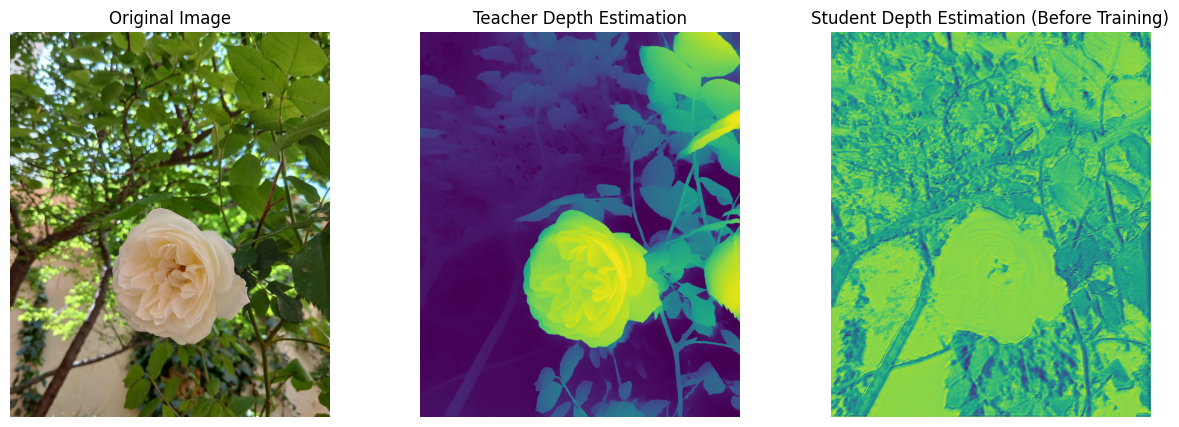

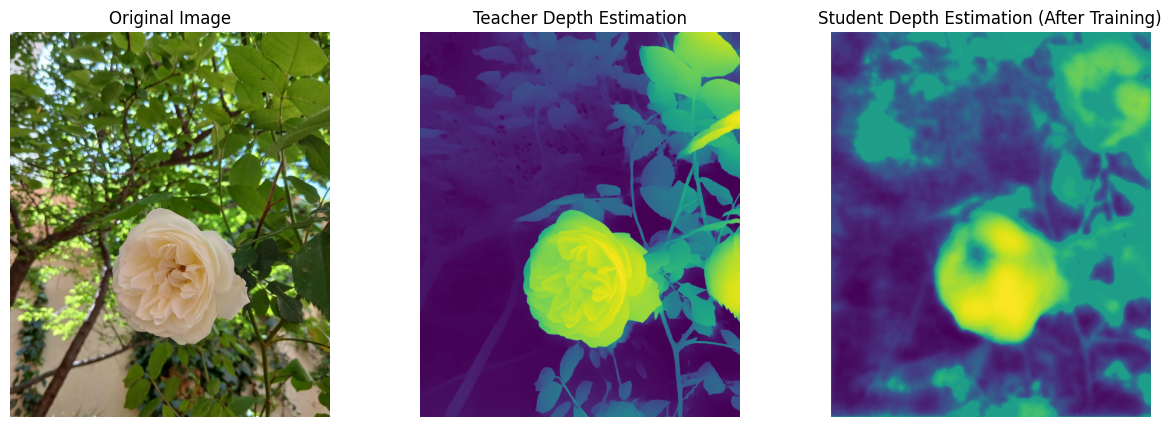

In [29]:
# Load image
image_path = "/content/drive/MyDrive/images/image1.JPG"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

input_tensor = eval_transform(Image.fromarray(image)).unsqueeze(0).to(device)

# Set models to evaluation mode
teacher_model.eval() # Use the DepthModel instance
student_model.eval() # Use the DepthModel instance


with torch.no_grad():
    # Student prediction (before training) using the DepthModel instance
    start_time = time.time()
    student_output_after = student_model(input_tensor)
    end_time = time.time()
    inference_time_ms = (end_time - start_time) * 1000
    print(f"✅ Student model inference time: {inference_time_ms:.2f} ms")

    student_output_after_training = student_output_after.squeeze().cpu().numpy()

    # Teacher prediction using the DepthModel instance
    teacher_depth = teacher_model(input_tensor)
    teacher_depth = teacher_depth.squeeze().cpu().numpy()

# loss = distillation_criterion(student_output_after_training, teacher_depth)
# print(loss.item())
#Befor training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_depth_before_training_train_image, cmap="viridis")
plt.title("Student Depth Estimation (Before Training)")
plt.axis("off")

plt.show()

#After training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_output_after_training, cmap="viridis")
plt.title("Student Depth Estimation (After Training)")
plt.axis("off")

plt.show()



### On Testing

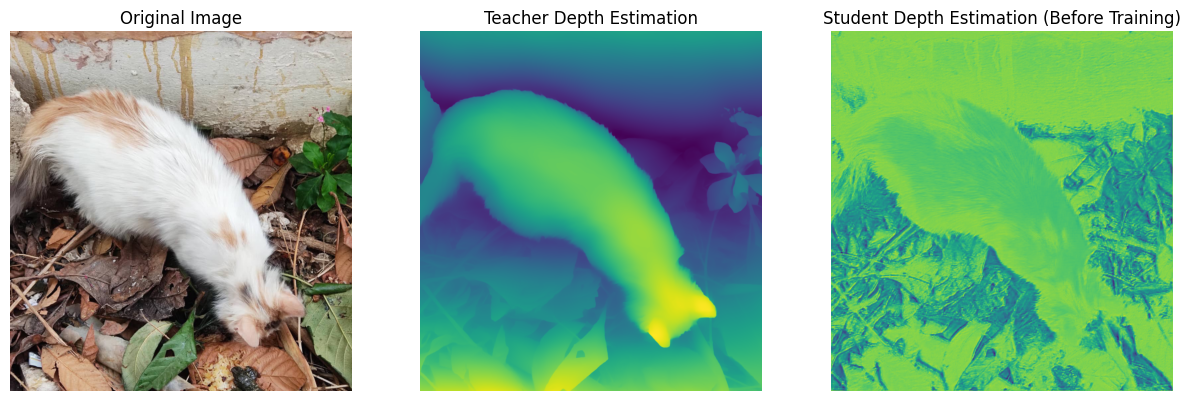

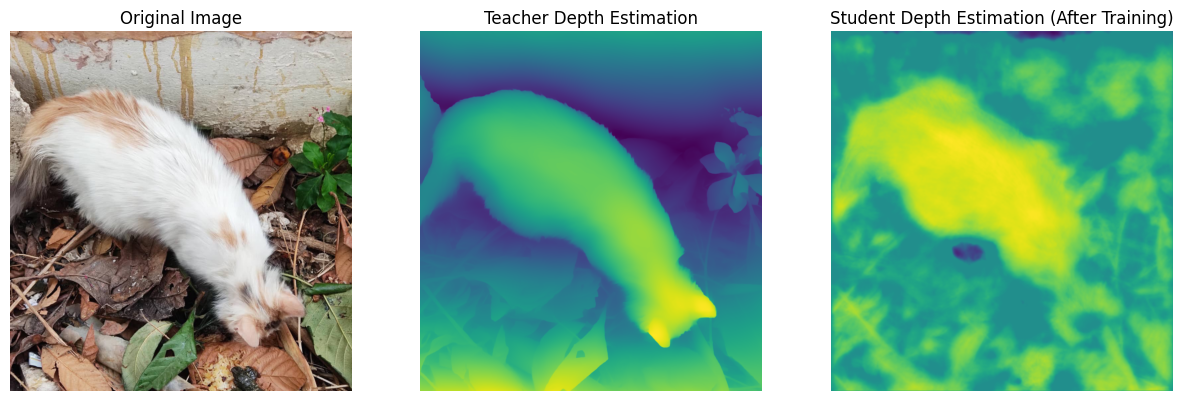

In [30]:
# Load image
image_path = "/content/test.jpg"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB

input_tensor = eval_transform(Image.fromarray(image)).unsqueeze(0).to(device)

# Set models to evaluation mode
teacher_model.eval() # Use the DepthModel instance
student_model.eval() # Use the DepthModel instance

loss = 0;
with torch.no_grad():
    # Student prediction (before training) using the DepthModel instance
    student_output_after = student_model(input_tensor)
    student_output_after_training = student_output_after.squeeze().cpu().numpy()

    # Teacher prediction using the DepthModel instance
    teacher_depth = teacher_model(input_tensor)
    # loss = distillation_criterion(student_output_after, teacher_depth)
    teacher_depth = teacher_depth.squeeze().cpu().numpy()

# print(loss.item())
#Befor training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_depth_before_training, cmap="viridis")
plt.title("Student Depth Estimation (Before Training)")
plt.axis("off")

plt.show()

#After training
plt.figure(figsize=(15, 5))

# Original Image
plt.subplot(1, 3, 1)
plt.imshow(image)
plt.title("Original Image")
plt.axis("off")

# Teacher Depth Map
plt.subplot(1, 3, 2)
plt.imshow(teacher_depth, cmap="viridis")
plt.title("Teacher Depth Estimation")
plt.axis("off")

# Student Depth Map
plt.subplot(1, 3, 3)
plt.imshow(student_output_after_training, cmap="viridis")
plt.title("Student Depth Estimation (After Training)")
plt.axis("off")

plt.show()